In [1]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [2]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [11]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 159834.140019 - 60 # showing starting 1 minute before the seizure
end_time_sec = 159834.140019 + 77.8599809999868

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'HUP225_phaseII'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [14]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(50))



In [15]:
start_time_usec, end_time_usec

(159774140019.0, 159912000000.0)

In [16]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [25]:
np.size(signal_ref)

4799746

In [26]:
signal_ref

,RA01-RA02,RA02-RA03,RA03-RA04,RA04-RA05,RA05-RA06,RA06-RA07,RA07-RA08,RA08-RA09,RA09-RA10,RA10-RA11,...,RC05-RC06,RC06-RC07,RC07-RC08,RC08-RC09,RC09-RC10,RC10-RC11,RC11-RC12,RD01-RD02,RD02-RD03,RD03-RD04
1 days 20:22:54.140019,-0.033379,8.874902,-4.403708,-3.661412,20.277235,-5.852976,31.041999,-20.445852,-10.951159,-1.022486,...,-12.349318,11.340146,1.490813,-37.410255,51.331554,-4.907976,4.008374,4.307700,6.870740,-3.480721
1 days 20:22:54.140995567,1.782367,7.570643,-5.051882,-3.038727,19.156641,-5.284048,32.444899,-21.241286,-10.778733,-0.000075,...,-14.454145,12.166795,3.058744,-40.232608,52.986319,-6.158563,3.974787,3.649604,7.906339,-0.531726
1 days 20:22:54.141972134,2.714954,7.325739,-5.341267,-2.569637,18.111182,-4.827672,33.730889,-21.932300,-10.822321,0.922903,...,-16.075702,12.755772,3.897801,-43.119828,54.932609,-7.091806,3.727696,2.847604,9.210461,2.410403
1 days 20:22:54.142948700,2.181119,8.733883,-5.181530,-2.380137,17.287526,-4.547476,34.745224,-22.354915,-11.215899,1.653857,...,-16.964965,12.982782,3.587370,-46.078288,57.377791,-7.549367,3.121746,1.850323,10.971162,5.268664
1 days 20:22:54.143925267,0.058789,11.717947,-4.794324,-2.534915,16.902549,-4.443980,35.313786,-22.323501,-11.978948,2.144180,...,-17.185729,12.877044,2.158651,-49.030311,60.399905,-7.607840,2.145405,0.704514,13.249228,7.910372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1 days 20:25:11.996093733,-38.651416,36.359357,-18.265989,24.386012,7.348718,2.471738,32.687877,-48.221184,-16.365740,-11.919396,...,56.253547,-17.327137,10.508172,11.355973,-17.520415,-39.045902,-28.255610,-8.154529,21.754332,23.726422
1 days 20:25:11.997070300,-36.022493,35.639472,-19.632690,22.204562,7.142955,4.824633,34.100507,-46.997069,-16.582335,-12.277136,...,55.505105,-16.772378,5.387683,11.641340,-16.676361,-36.189237,-26.921163,-8.119614,21.279692,23.563087
1 days 20:25:11.998046866,-33.073838,33.763809,-19.169206,20.042054,11.704563,1.683441,35.830497,-45.284882,-16.281008,-12.913164,...,51.343426,-15.928255,4.216229,10.814367,-14.945712,-33.479345,-25.581340,-7.616110,20.373945,21.280410
1 days 20:25:11.999023433,-30.094498,30.916477,-16.524794,17.761632,18.921277,-5.414189,38.575604,-43.099153,-15.530369,-13.657407,...,43.718673,-14.798753,6.882103,9.122835,-12.421048,-30.964302,-24.268652,-6.626022,19.062657,16.899105


In [27]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

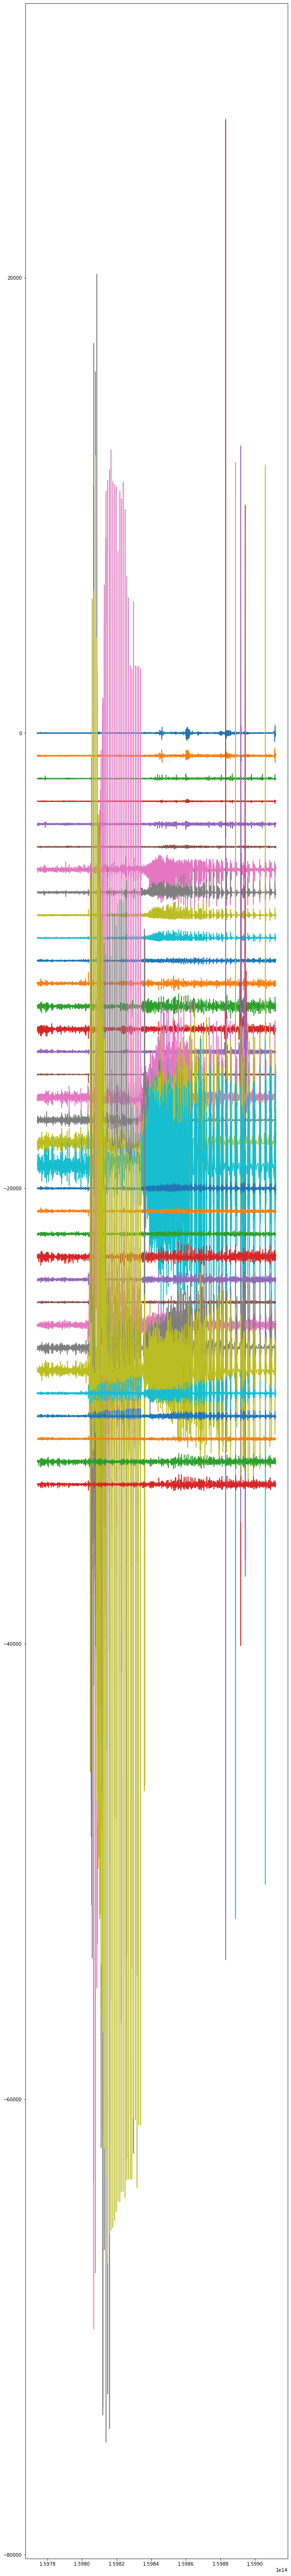

In [29]:
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:34] + np.arange(34)*-1000)